# Analysis Part 1: Calculation of audio signal envelope and power differences
This notebook runs the analysis based on the envelope of the audio signals and plots some results. The calculations are performed for all data files unless an appropriate results file already exists. The results are saved as a pandas pkl file named *rms_analysis_data.pkl*. The envelope of the audio signals is estimated as the root-mean-square (RMS). The power is yielded by integrating the RMS over time. Next to the whole RMS traces, cutouts before, during, and after each stimulation are averaged for stimuli of the same intensity. The results are grouped by the experimental conditions and some simple plots are created.

Author:         Bjarne Schultze <br>
Last modified:  30.11.2023

In [1]:
import numpy as np
import h5py
import pandas as pd
import re
import matplotlib.pyplot as plt
import opto_analysis_fun as oafun

# Use my own plot style
plt.style.use('./plotstyle_bjarne.mplstyle')  
# Define two colors indicating activation and inactivation
act_col = '#DB0D55'
iact_col = '#5B9403'

#### Preparations

In [2]:
# Load the file with the experiment names and condition information
experiments = pd.read_csv("experiments_list.txt", delimiter=' ', names=["directory","group","flyline","food"])
# Convert string with food information into python list
for i in range(len(experiments)):
    experiments.at[i,"food"] = experiments.at[i,"food"].strip('][').split(',')

# Try to load the analysis data
try:
    analysis_data = pd.read_pickle("./rms_analysis_data.pkl")
    uinput = 'n'
except FileNotFoundError:
    print("The file was not found! You might need to run the analysis again.")
    uinput = input("Do you want to run the analysis again now? [y/n] ")

# Set the path where the data is stored
dat_path = 'D:/BehaviorData/Research_module_drosophila/'

# Set number of audio channels
n_audio_chan = 3

#### Main analysis loop

In [3]:
if uinput.lower() == 'y':
    print('Analysis started ...')

    # Initialize an empty data frame to collect the results
    analysis_data = pd.DataFrame()

    # Iterate over all datasets
    for filenum,file in enumerate(experiments["directory"]):
        # Load and the current dataset and extract the recording channels
        filename = dat_path+file+'/'+file+'_daq.h5'
        data_in = h5py.File(filename)
        print(f'Working on file: {filename}')
        dataset = np.array(data_in['samples'])
        # Get the sampling rate
        sampling_rate = round(np.mean(data_in['samplenumber']))
        # Create a time vector
        time_vec = np.arange(0, dataset.shape[0]/sampling_rate, 1/sampling_rate)
        # Close file
        data_in.close()

        # Mean-center the data
        audio_data = oafun.mean_center(dataset[:,:n_audio_chan])
        # Calculate the root-mean-square of the signal (envelop estimation, energy)
        rms_sig = oafun.rolling_rms(audio_data, 100)

        # Analyze the light stimulus to get on- and offsets as well as stimulation voltage values
        light, stim_mode, stim_on, stim_off, stim_volt = oafun.analyze_light_stim(dataset[:,n_audio_chan:])
        stim_volt_u = np.unique(stim_volt)

        # Calculate the power from the RMS signal before, during and after stimulation
        power, power_pre, power_post = oafun.signal_power(rms_sig, time_vec, stim_on, stim_off)
        # Average the power difference relative to 5 s before stimulation over all stimuli of the same intensity
        m_power = np.array([ np.mean(power[stim_volt == uval] - power_pre[stim_volt == uval],axis=0) for uval in stim_volt_u ])
        m_power_post = np.array([ np.mean(power_post[stim_volt == uval] - power_pre[stim_volt == uval],axis=0) for uval in stim_volt_u ])

        # Split the data from one dataset into the three channels/chambers and store them as separate entries
        for chan in range(n_audio_chan):
            if experiments.at[filenum,"food"][chan] != 'None':
                current_data = pd.concat([experiments.loc[filenum,:], pd.Series({"food_grp":experiments.at[filenum,"food"][chan],"rms":rms_sig[:,chan],"power":power[:,chan],"power_pre":power_pre[:,chan],"power_post":power_post[:,chan],
                                                                                "m_power":m_power[:,chan],"m_power_post":m_power_post[:,chan], "stim_mode":stim_mode,"stim_volt":stim_volt,"stim_volt_u":stim_volt_u,
                                                                                "stim_on":stim_on,"stim_off":stim_off})])
                analysis_data = pd.concat([analysis_data,current_data], axis=1)

    # Format the analysis data frame
    analysis_data = analysis_data.transpose().reset_index().drop(["food","index"], axis=1)


    # Create a label for each condition
    label = []
    for exp in range(len(analysis_data)):
        label.append("_".join([analysis_data.at[exp,"flyline"], analysis_data.at[exp,"stim_mode"][:3], analysis_data.at[exp,"food_grp"][:3]]))
    # Add labels to the data frame
    analysis_data = pd.concat([analysis_data,pd.Series(label,name="label")], axis=1)

    # Save the analysis data
    out_file = "rms_analysis_data.pkl" 
    pd.to_pickle(analysis_data, "./" + out_file)

    # Print finish message
    print(f"Finished analysis! Results saved as {out_file}.")

#### Collect and average data within conditions

In [4]:
# Allocate variables to collect the mean power values during stimulation
mean_powers = []
mean_powers_post = []
stim_volts = []
# Get the conditions and re-sort them for plotting
resort_idx = [3,2,4,6,0,1,7,9,5,8]
conditions = analysis_data["label"].unique()[resort_idx]


# Iterate over all conditions (labels in the label column)
for cond in conditions:
    # Find indices of current condition
    cond_idx = analysis_data.loc[:,'label'] == cond
    
    # Append data per condition
    mean_powers.append(analysis_data.loc[cond_idx,"m_power"].tolist())
    mean_powers_post.append(analysis_data.loc[cond_idx,"m_power_post"].tolist())
    stim_volts.append(analysis_data.loc[cond_idx,"stim_volt_u"].tolist())

## Plotting of results

In [5]:
# Load the calibration table for the light intensities
opto_cal = np.loadtxt('opto_calibration.txt', skiprows=1)
cal_volt = opto_cal[:,0]
stim_red = opto_cal[:,1:4].mean(axis=1)     # intensities of red light
stim_green = opto_cal[:,4:].mean(axis=1)    # intensities of green light

# Map voltage and light intensities in dicts
rstim_cal_dict = { v:round(rs,1) for v,rs in zip(cal_volt,stim_red) } 
gstim_cal_dict = { v:round(gs,1) for v,gs in zip(cal_volt,stim_green) }

### Plot average power difference before and during stimulation

In [8]:
# Create title for the subplots
plotting_titles = {'VT41688_act_ret':'dPR1>CsChrimson (VT41688)', 'VT41688_act_con':'dPR1>CsChrimson (VT41688)', 
                   'VT41688_ina_ret':'dPR1>GtACR1 (VT41688)','VT41688_ina_con':'dPR1>GtACR1 (VT41688)', 
                   'VT5534_act_ret':'vPR6>CsChrimson (VT5534)', 'VT5534_act_con':'vPR6>CsChrimson (VT5534)',
                   'VT5534_ina_ret':'vPR6>GtACR1 (VT5534)', 'VT5534_ina_con':'vPR6>GtACR1 (VT5534)', 
                   'VT19579_ina_ret':'vPR6>GtACR1 (VT19579)','VT19579_ina_con':'vPR6>GtACR1 (VT19579)'}

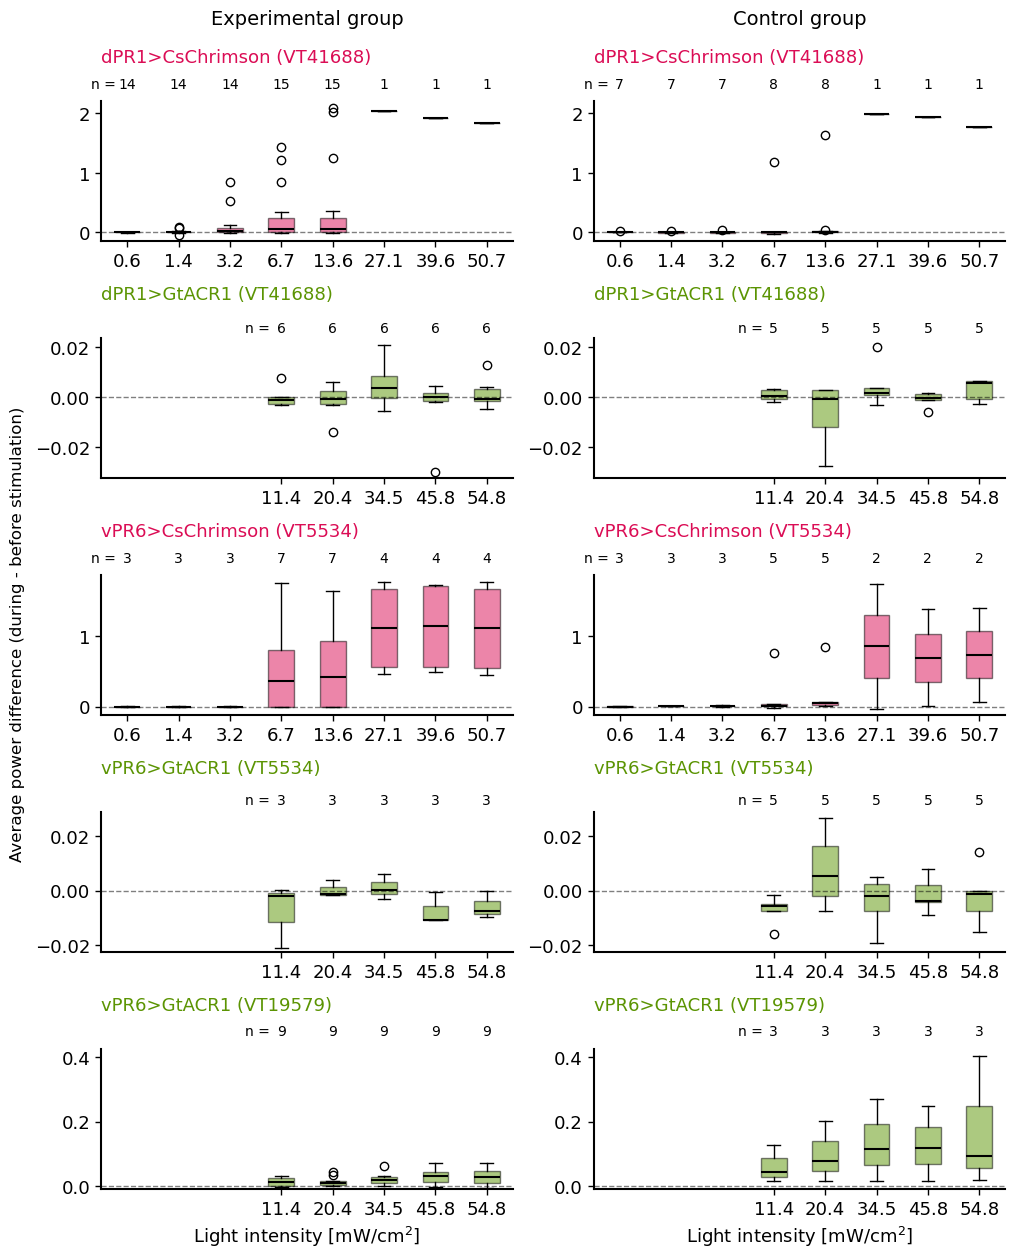

In [36]:
# Set up a new figure
fig, ax = plt.subplots(5, 2, figsize=(10,12))
ax = ax.flatten()

# Iterate over all conditions
for cidx, cond in enumerate(conditions):
    # Flaten and then sort/group values according to stimuli
    mpwr_fl = np.concatenate(mean_powers[cidx])
    stim_fl = np.concatenate(stim_volts[cidx])
    stim_srted = np.unique(stim_fl)                             # unique stimulus intensities
    mpwr_srted = [ mpwr_fl[stim_fl == i] for i in stim_srted ]  # mean powers sorted according to stimulus values

    # Distinguish activation and inactivation
    if len(re.findall('act', cond)) > 0: 
        light_stim = [ rstim_cal_dict[key] for key in stim_srted ]
        stim_col = act_col
    elif len(re.findall('ina', cond)) > 0: 
        light_stim = [ gstim_cal_dict[key] for key in stim_srted ]
        stim_col = iact_col

    # Ensure the same x axis limits for all subplots
    if len(light_stim) < 8:
        ax[cidx].set_xlim((-2.5, 5.5))
    
    # Get the n per stimulus intensity
    n_cond_stim = [ len(i) for i in mpwr_srted ]

    x_mpwr = np.zeros((len(stim_fl),))
    for i,e in enumerate(stim_srted):
        x_mpwr[stim_fl == e] = i+1

    # Show the average power differences as boxplots
    bxplt = ax[cidx].boxplot(mpwr_srted, labels=light_stim, patch_artist=True)
    # Change the color of the boxplots according to the stimulation
    for patch in bxplt['boxes']:
        patch.set_facecolor(stim_col)
        patch.set_alpha(0.5)

    # Adjust y limits and add sample sizes
    if cidx % 2 == 1:
        # Set equal y limits per row
        ylims = [ax[cidx-1].get_ylim(), ax[cidx].get_ylim()]
        ax[cidx].set_ylim([np.min(ylims),np.max(ylims)])
        ax[cidx-1].set_ylim([np.min(ylims),np.max(ylims)])

        # Get the x tick values (not trivial since they are boxplots)
        xticks = ax[cidx].get_xticks()
        # Add the sample size n for each boxplot to the subplot (right column)
        for i,n in enumerate(n_cond_stim):
            ax[cidx].text(xticks[i], 1.1 * np.max(ylims), n, horizontalalignment='center')
        # Set a label for the sample size at the left most position
        ax[cidx].text(xticks[0]-0.7, 1.1 * np.max(ylims), 'n =')

        # Add the sample size n for each boxplot to the subplot (left column)
        for i,n in enumerate(n_cond_stim_prev):
            ax[cidx-1].text(xticks_prev[i], 1.1 * np.max(ylims), n, horizontalalignment='center')
        # Set a label for the sample size at the left most position
        ax[cidx-1].text(xticks_prev[0]-0.7, 1.1 * np.max(ylims), 'n =')
    else:
        # Store the x ticks and sample sizes 
        xticks_prev = ax[cidx].get_xticks()
        n_cond_stim_prev = n_cond_stim

    # Insert a reference line at zero
    ax[cidx].axhline(0, color='k', linestyle='--', alpha=0.5)
    # Add a title indicating the fly line
    ax[cidx].set_title(plotting_titles[cond], loc='left', color=stim_col, pad=28)
    # Force a tight layout for the subplot
    plt.tight_layout()

# Add a common y axis label for all subplots
fig.supylabel("Average power difference (during - before stimulation)", x=-0.01)
# Label the x axes
ax[-1].set_xlabel(r'Light intensity [mW/cm$^2$]')
ax[-2].set_xlabel(r'Light intensity [mW/cm$^2$]')
# Common titles for the experimental and control column
xcenter = np.mean(ax[0].get_xlim())
ax[0].text(xcenter, 3.5, "Experimental group", size=14, horizontalalignment='center')
ax[1].text(xcenter, 3.5, "Control group", size=14, horizontalalignment='center')

# Save figure
# fig.savefig('./Report/figures/bxplt_pwr_differences.pdf', bbox_inches='tight')

### Plot the development of the power difference over stimulus intensity (for each experiment)

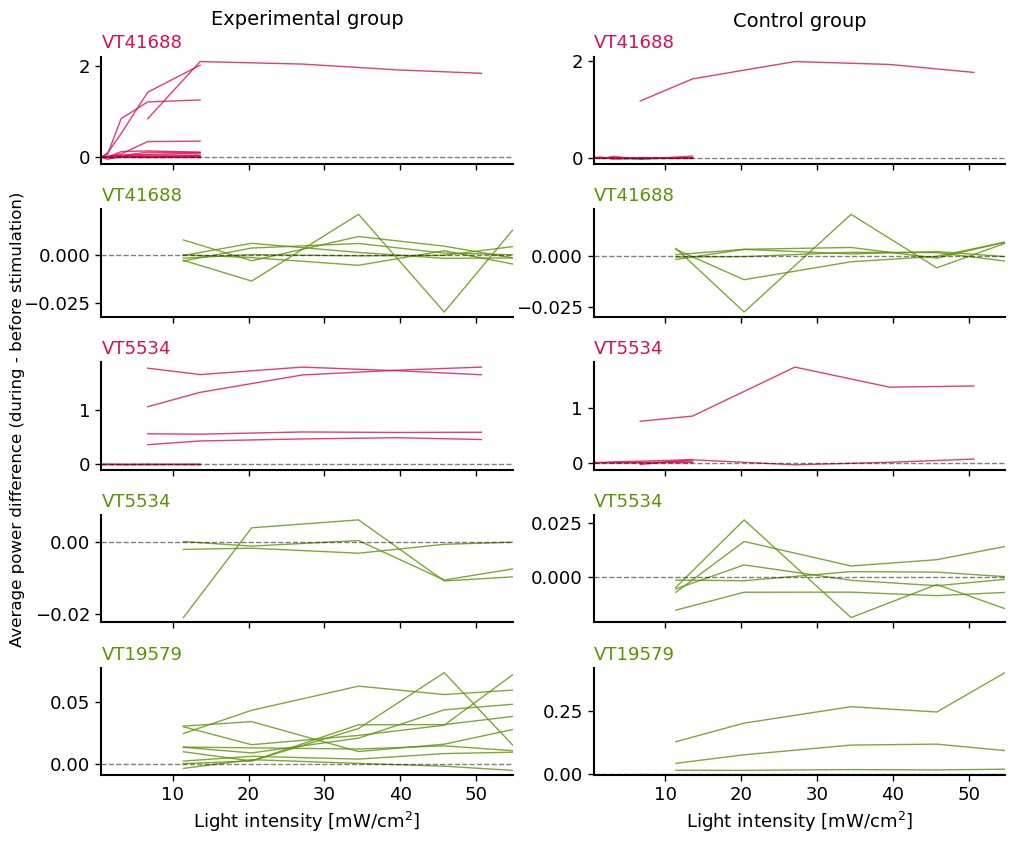

In [15]:
# Set up a new figure
fig, ax = plt.subplots(5, 2, figsize=(10,8), sharex=True)
ax = ax.flatten()

for cidx, cond in enumerate(conditions):
    # Select the data of the current condition
    curr_pwr = mean_powers[cidx]
    curr_stim = stim_volts[cidx]

    # Distinguish between activation and inactivation
    if len(re.findall('act', cond)) > 0: 
        cal_dict = rstim_cal_dict
        stim_col = act_col
    elif len(re.findall('ina', cond)) > 0: 
        cal_dict = gstim_cal_dict
        stim_col = iact_col

    # Plot the stimulus-power development for each experiment as a separate line
    for pwr,stim in zip(curr_pwr, curr_stim):
        light_stim = [ cal_dict[key] for key in stim ]          # Find the light intensities for all stimulus voltages
        ax[cidx].plot(light_stim, pwr, '-', color=stim_col, alpha=0.8)

    # Add a reference line at zero
    ax[cidx].axhline(0, color='k', linestyle='--', alpha=0.5)
    # Add a title stating the condition
    ax[cidx].set_title(re.findall('VT[0-9]+',cond)[0], color=stim_col, loc='left')
    # Force a tight layout
    ax[cidx].autoscale(axis='x', tight=True)
    plt.tight_layout()

# Add labels
ax[-1].set_xlabel(r'Light intensity [mW/cm$^2$]')
ax[-2].set_xlabel(r'Light intensity [mW/cm$^2$]')
fig.supylabel("Average power difference (during - before stimulation)", x=-0.01)

# Add titles per column stating experimental and control group
xcenter = np.mean(ax[0].get_xlim())
ax[0].text(xcenter, 2.9, "Experimental group", size=14, horizontalalignment='center')
ax[1].text(xcenter, 2.7, "Control group", size=14, horizontalalignment='center')

# Save plot
# fig.savefig('./Report/figures/mean_pwr_tuning.pdf')

### Plot average RMS traces during stimulation

In [38]:

# Collect the rms from before to after stimulation and average within one experiment for stimuli of the same intensity
m_rms_clips = []
stims = []

# Iterate over all experiments
for exp in range(len(analysis_data)):
    # Extract the stimulus timings
    stim_on = analysis_data.at[exp,'stim_on']
    stim_off = analysis_data.at[exp,'stim_off']
    stim_len = stim_off[0] - stim_on[0]
    # Extract the stimulation voltage values
    stim_volt = analysis_data.at[exp, 'stim_volt']
    stim_volt_u = np.unique(stim_volt)

    # Extract the RMS traces from 5 s before to 5 s after stimulation
    rms_clips = np.array([ analysis_data.loc[exp,'rms'][start-stim_len:stop+stim_len] for start,stop in zip(stim_on,stim_off) ])
    
    # Average the traces for stimuli of the same intensity
    m_rms_clips.append(np.array([ np.mean(rms_clips[stim_volt == v], axis=0) for v in stim_volt_u ]))
    # Store the stimuli corresponding to the entries in m_rms_clips
    stims.append(stim_volt_u)

# Convert collected data to np.arrays
m_rms_clips = np.array(m_rms_clips)
stims = np.array(stims)

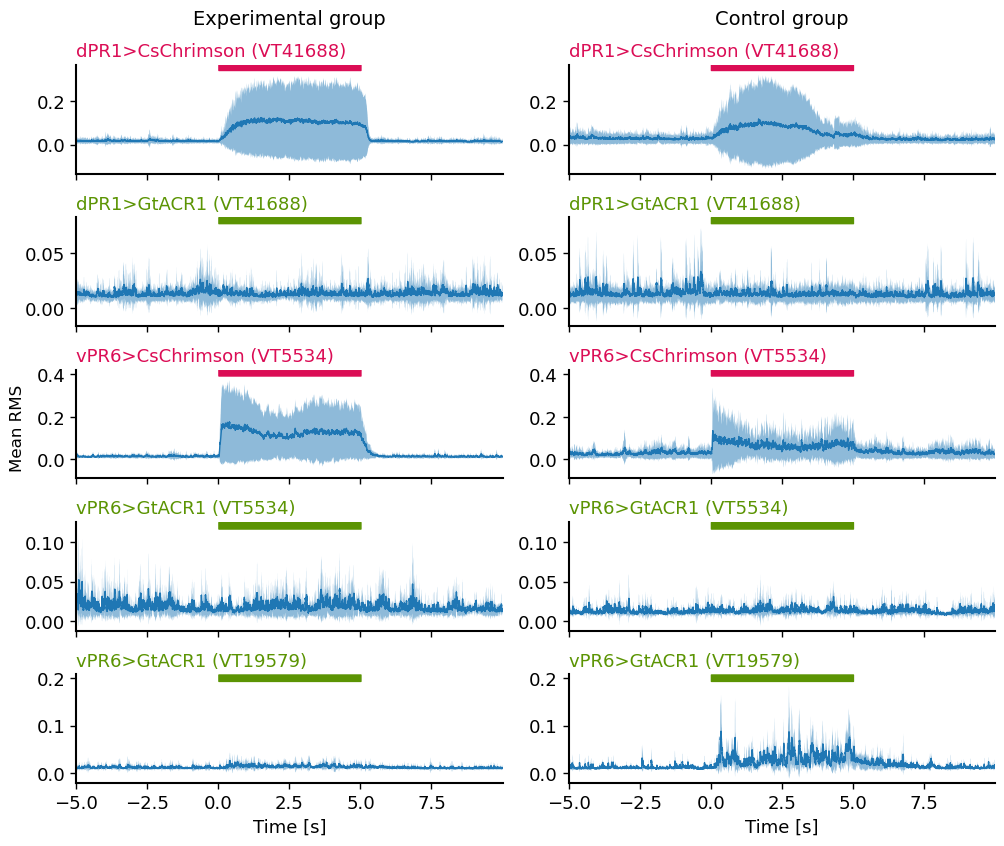

In [50]:
# Get the conditions and re-sort them for plotting
resort_idx = [3,2,4,6,0,1,7,9,5,8]
conditions = analysis_data["label"].unique()[resort_idx]
# Set the sampling frequency for the creation of a time vector
fs = 10000

# Set up a new figure
fig, ax = plt.subplots(5, 2, figsize=(10,8), sharex=True)
ax = ax.flatten()

# Iterate over all conditions
for i, cond in enumerate(conditions):
    # Find indices of current condition
    cond_idx = analysis_data.loc[:,'label'] == cond
    cond_data = m_rms_clips[cond_idx,:,:]
    cond_stim = stims[cond_idx,:]
    # Create a time vector and a subset for the stimulation 
    time_vec = np.arange(-cond_data.shape[2]/3/fs, cond_data.shape[2]/3/fs * 2, 1/fs)
    stim_time = time_vec[np.logical_and(time_vec >= 0, time_vec < 5)]

    # Select the data of one stimulus intensity (default 1 mV)
    stim_sel = cond_stim == 1
    stim_sel_data = cond_data[stim_sel,:] 

    # Distinguish between activation and inactivation
    if len(re.findall('act', cond)) > 0:
        stim_col = act_col
    elif len(re.findall('ina', cond)) > 0:
        stim_col = iact_col

    # Calculate mean and standard deviation for over all traces of one condition
    curr_mean = np.mean(stim_sel_data,axis=0)
    curr_sd = np.std(stim_sel_data,axis=0)

    # Set the y limits of the data to plot a bar above
    ylimits = [0, 1.1 * np.max(curr_mean+curr_sd)]

    # Plot the mean RMS trace +- one standard deviation
    ax[i].fill_between(time_vec, curr_mean-curr_sd, curr_mean+curr_sd, alpha=0.5)
    ax[i].plot(time_vec, curr_mean)

    # Adjust y limits
    if i % 2 == 1:
        # Set equal y limits per row
        ylims = [ax[i-1].get_ylim(), ax[i].get_ylim()]
        ylims = [np.min(ylims),np.max(ylims)]
        ax[i].set_ylim([ylims[0],ylims[1]+0.07*ylims[1]])
        ax[i-1].set_ylim([ylims[0],ylims[1]+0.07*ylims[1]])
        # Add a bar which indicates the time of stimulation and the kind of stimulation
        ax[i].fill_between(stim_time, ylims[1], ylims[1]+0.07*ylims[1], color=stim_col)
        ax[i-1].fill_between(stim_time, ylims[1], ylims[1]+0.07*ylims[1], color=stim_col)

    # Set an appropriate title
    ax[i].set_title(plotting_titles[cond], loc='left', color=stim_col)
    # Adjust to tight layout
    ax[i].autoscale(axis='x', tight=True)
    plt.tight_layout()

# Common y axis title for all subplots
fig.supylabel("Mean RMS", x=0)
# x axis labels for lower subplots
ax[-1].set_xlabel("Time [s]")
ax[-2].set_xlabel("Time [s]")
# Common title for experimental and control column
xcenter = np.mean(ax[-1].get_xlim())
ax[0].text(xcenter,0.55, "Experimental group", size=14, horizontalalignment='center')
ax[1].text(xcenter,0.55, "Control group", size=14, horizontalalignment='center')

# Save figure
# fig.savefig('./Report/figures/mean_rms_traces.pdf', bbox_inches='tight')